# **Measuring Efficacy in clustering**


This notebook is a tutorial on auditing efficacy within a clustering task. We will use the _holisticai_ library throughout.

The sections are organised as follows :

1. Load the data : we load the adult dataset as a pandas DataFrame
2. Pre-Processing and Train a Model : we train a kmeans model (sklearn)
3. Measure efficacy : we compute a few efficacy metrics.

## **1. Load the data**

We will start by importing the adult dataset, which we host on our library. The adult dataset contains a set of informations extract from US 1994 Census database. It includes personal information about the individuals, specifically sex, race, and education. In this tutorial we will perform unsupervised learning to cluster the data, then measure whether this clustering contains gender or race information (clustering bias).

In [1]:
from holisticai.datasets import load_dataset

dataset = load_dataset("adult")
dataset

Dataset({
        features: ['X', 'y'],
        num_rows: 45222
    })

## **2. Preprocess data and Train a model**

In [2]:
ds = dataset.train_test_split(test_size=0.2, shuffle=True)
x_train = ds['train']['X']
x_test = ds['test']['X']

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


ks = range(1, 8)
inertias = []
for k in ks:
    # create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)
    
    # fit model to samples
    model.fit(x_train)
    
    # append the inertia to the list of inertias
    inertias.append(model.inertia_)

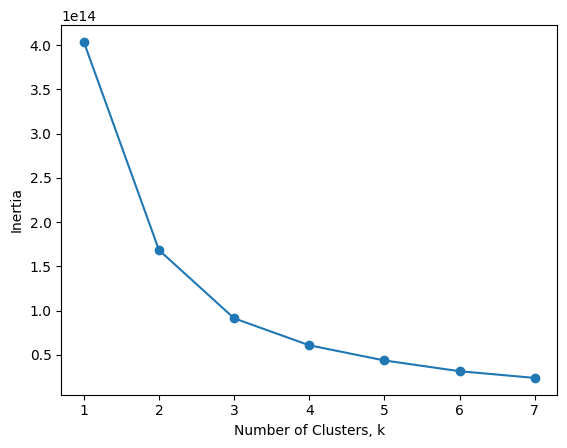

In [4]:
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [5]:
# we choose to use 4 clusters
model = KMeans(n_clusters = 4)
model.fit(x_train)

# predict
y_pred = model.predict(x_test)

## **3. Measure Efficacy**

In [6]:
from holisticai.efficacy.metrics import clustering_efficacy_metrics
clustering_efficacy_metrics(x_test, y_pred)

,Value,Reference
Metric,,
Silhouette,0.557919,1.0
Calinski Harabasz,18656.218809,inf
Davies Bouldin,0.575384,0.0
